In [1]:
from __future__ import print_function
import os, sys, time
import argparse
import cv2 as cv
import numpy as np
import random # import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
import kornia as tgm

from model import DexiNet
from losses import weighted_cross_entropy_loss
from dexi_utils import cv_imshow, dataset_info

In [2]:
def weight_init(m):
    if isinstance(m, (nn.Conv2d, )):

        torch.nn.init.normal_(m.weight,mean=0, std=0.01)
        if m.weight.data.shape[1]==torch.Size([1]):
            torch.nn.init.normal_(m.weight, mean=0.0,)
        if m.weight.data.shape==torch.Size([1,6,1,1]):
            torch.nn.init.constant_(m.weight,0.2)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    # for fusion layer
    if isinstance(m, (nn.ConvTranspose2d,)):

        torch.nn.init.normal_(m.weight,mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, std=0.1)

        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [3]:
device = torch.device('cpu' if torch.cuda.device_count() == 0 else 'cuda:1')
model = DexiNet().to(device)
# model = nn.DataParallel(model)
model.apply(weight_init)

DexiNet(
  (block_1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block_2): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dblock_3): _DenseBlock(
    (denselayer1): _DenseLayer(
      (conv1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (norm1): BatchNorm2d(256, eps=1e-05, momentum

In [4]:
class testDataset(Dataset):
    def __init__(self, data_root, arg = None):
        self.data_root = data_root
        self.arg = arg
        self.transforms = transforms
        self.mean_bgr = arg.mean_pixel_values[0:3] if len(arg.mean_pixel_values)==4\
            else arg.mean_pixel_values

        self.data_index = self._build_index()


    def _build_index(self):
        sample_indices = []        
        if not self.arg.test_data == "CLASSIC":
            list_name = os.path.join(self.data_root,self.arg.test_list)#os.path.abspath(self.data_root)
            with open(list_name,'rb') as f:
                files = f.readlines()

            files = [line.strip() for line in files]

            pairs = [line.split() for line in files]
            images_path = [line[0] for line in pairs]
            labels_path = [line[1] for line in pairs]
            sample_indices = [images_path,labels_path]
        else:
            # for single image testing
            images_path = os.listdir(self.data_root)
            labels_path = None
            sample_indices = [images_path, labels_path]
        return sample_indices

    def __len__(self):
        return len(self.data_index[0])

    def __getitem__(self, idx):
        # get data sample
        # image_path, label_path = self.data_index[idx]
        print(self.data_index)
        image_path = self.data_index[0][idx]
        label_path = self.data_index[1][idx] if not self.arg.test_data=="CLASSIC" else None
        img_name = os.path.basename(image_path)
        file_name = img_name[:-3]+"png"

        # base dir
        if self.arg.test_data.upper() == 'BIPED':
            img_dir = os.path.join(self.arg.input_val_dir,'imgs','test')
            gt_dir = os.path.join(self.arg.input_val_dir,'edge_maps','test')
        elif self.arg.test_data.upper() == 'CLASSIC':
            img_dir = self.arg.input_val_dir
            gt_dir = None
        else:
            img_dir = self.arg.input_val_dir
            gt_dir = self.arg.input_val_dir

        # load data
        image = cv.imread(os.path.join(img_dir,image_path), cv.IMREAD_COLOR)
        if not self.arg.test_data == "CLASSIC":
            label = cv.imread(os.path.join(gt_dir,label_path), cv.IMREAD_COLOR)
        else:
            label=None

        im_shape =[image.shape[0],image.shape[1]]
        image, label = self.transform(img=image, gt=label)

        return dict(images=image, labels=label, file_names=file_name,image_shape=im_shape)

    def transform(self, img, gt):

        # gt[gt< 51] = 0 # test without gt discrimination
        if self.arg.test_data=="CLASSIC":
            img_height = img.shape[0] if img.shape[0] % 16 == 0 else ((img.shape[0] // 16) + 1) * 16
            img_width = img.shape[1] if img.shape[1] % 16 == 0 else ((img.shape[1] // 16) + 1) * 16
            print('Real-size:',img.shape, "Ideal size:",[img_height,img_width])
            img = cv.resize(img, (self.arg.test_im_width,self.arg.test_im_height))
            gt = None
        elif img.shape[0]<512 or img.shape[1]<512:
            img = cv.resize(img, (512, 512))
            gt = cv.resize(gt, (512, 512))
        elif img.shape[0]%16!=0 or img.shape[1]%16!=0:
            img_width = ((img.shape[1] // 16) + 1) * 16
            img_height = ((img.shape[0] // 16) + 1) * 16
            img = cv.resize(img, (img_width, img_height))
            gt = cv.resize(gt, (img_width, img_height))


        # if self.yita is not None:
        #     gt[gt >= self.yita] = 1
        img = np.array(img, dtype=np.float32)
        # if self.rgb:
        #     img = img[:, :, ::-1]  # RGB->BGR
        if not self.arg.test_data=="CLASSIC":
            gt = np.array(gt, dtype=np.float32)
            if len(gt.shape) == 3:
                gt = gt[:, :, 0]
            gt /= 255.
            gt = torch.from_numpy(np.array([gt])).float()
        else:
            gt = np.zeros((img.shape[:2]))
            gt=torch.from_numpy(np.array([gt])).float()
        img -= self.mean_bgr
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img.copy()).float()

        return img, gt

In [5]:
def save_image_batch_to_disk(tensor, output_dir, file_names, img_shape=None,arg=None):
    os.makedirs(output_dir,exist_ok=True)
    output_dir_f = os.path.join(output_dir,'f')
    output_dir_a = os.path.join(output_dir,'a')
    os.makedirs(output_dir_f, exist_ok=True)
    os.makedirs(output_dir_a,exist_ok=True)
    # 255.0 * (1.0 - em_a)
    edge_maps = []
    for i in tensor:
        tmp = torch.sigmoid(i).cpu().detach().numpy()
        edge_maps.append(tmp)
    # edge_maps.append(tmp)
    tensor = np.array(edge_maps)
    idx =0
    image_shape = [x.cpu().detach().numpy() for x in img_shape]
    image_shape = [[y, x] for x, y in zip(image_shape[0], image_shape[1])]
    for i_shape, file_name in zip(image_shape,file_names):
        tmp = tensor[:,idx,...]
        tmp = np.transpose(np.squeeze(tmp),[0,1,2])
        preds = []
        for i in range(tmp.shape[0]):
            tmp_img = tmp[i]
            tmp_img[tmp_img<0.0] = 0.0
            tmp_img =255.0 * (1.0 - tmp_img)
            if not tmp_img.shape[1]==i_shape[0] or not tmp_img.shape[0]==i_shape[1]:
                tmp_img = cv.resize(tmp_img,(i_shape[0],i_shape[1]))
            preds.append(tmp_img)
            if i==6:
                fuse = tmp_img
        average = np.array(preds,dtype=np.float32)
        average = np.uint8(np.mean(average,axis=0))
        output_file_name_f = os.path.join(output_dir_f, file_name)
        output_file_name_a = os.path.join(output_dir_a, file_name)
        assert cv.imwrite(output_file_name_f, fuse)
        assert cv.imwrite(output_file_name_a, np.uint8(average))
        idx+=1


In [6]:
import argparse

parser = argparse.ArgumentParser(description='EdgeGen')
parser.add_argument('--test_data', type=str, default="CUSTOM", help='Name of the dataset.')
parser.add_argument('--input-val-dir', type=str,default="data", help='the path to the directory with the input data for validation.')
parser.add_argument('--output_dir', type=str, default='checkpoints', help='the path to output the results.')
parser.add_argument('--test_list', type=str, default=None, help='Name of the dataset.')
parser.add_argument('--checkpoint_data', type=str, default='24/24_model.pth', help='Just for testing') #  '19/19_*.pht'
parser.add_argument('--test_im_width', type=int, default=512, help='image height for testing')
parser.add_argument('--test_im_height', type=int, default=512, help='image height for testing')
parser.add_argument('--res_dir', type=str, default='result', help='Result directory')
parser.add_argument('--batch-size', type=int, default=8, metavar='B', help='the mini-batch size (default: 2)')
parser.add_argument('--num-workers', default=8, type=int, help='the number of workers for the dataloader.')
parser.add_argument('--mean_pixel_values', default=[104.00699, 116.66877, 122.67892, 137.86], type=float)  # [103.939,116.779,123.68] [104.00699, 116.66877, 122.67892]

input_args = [
    "--test_data", "CLASSIC",  # 'Name of the dataset'
    "--input-val-dir", "cats_generation",  # 'the path to the directory with the input data for validation.'
    "--test_list", "0.png", # 'Name of the dataset.'
    "--test_im_width", "256",  # 'image width for testing'
    "--test_im_height", "256",  # 'image height for testing'
    "--res_dir", 'results',  # 'Result directory'
    "--batch-size", "8", # 'the mini-batch size (default: 2)''
    "--num-workers", "8", # 'the number of workers for the dataloader.'
]

args = parser.parse_args(input_args)

In [31]:
dataset_val = testDataset("cats_generation", arg=args)
dataloader_val = DataLoader(dataset_val, batch_size=args.batch_size, shuffle=False, num_workers=0)

In [7]:
model.load_state_dict(torch.load(os.path.join(args.output_dir, args.checkpoint_data), map_location=device))
model.eval()

DexiNet(
  (block_1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block_2): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (dblock_3): _DenseBlock(
    (denselayer1): _DenseLayer(
      (conv1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (norm1): BatchNorm2d(256, eps=1e-05, momentum

In [32]:


output_dir = os.path.join(args.res_dir, "BIPED2" + args.test_data)
with torch.no_grad():
    for batch_id, sample_batched in enumerate(dataloader_val):
        images = sample_batched['images'].to(device)
        if not args.test_data == "CLASSIC":
            labels = sample_batched['labels'].to(device)
        file_names = sample_batched['file_names']
        image_shape = sample_batched['image_shape']
        print("input image size: ",images.shape)
        output = model(images)
        save_image_batch_to_disk(output, output_dir, file_names,image_shape, arg=args)

print("Testing ended in ", args.test_data, "dataset")

[['0.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png'], None]
Real-size: (256, 256, 3) Ideal size: [256, 256]
[['0.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png'], None]
Real-size: (256, 256, 3) Ideal size: [256, 256]
[['0.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png'], None]
Real-size: (256, 256, 3) Ideal size: [256, 256]
[['0.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png'], None]
Real-size: (256, 256, 3) Ideal size: [256, 256]
[['0.png', '

In [8]:
import PIL.Image

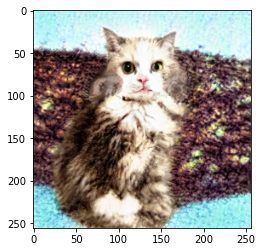

In [48]:
img = PIL.Image.open("cats_generation/0.png")
plt.imshow(img)
if True:
    img = img.resize((512, 512), PIL.Image.BICUBIC)
img_t = torch.tensor(np.array(img))  # unint8
tmp = (img_t - torch.tensor([104.00699, 116.66877, 122.67892][::-1]))
tmp = tmp.permute(2, 0, 1)

In [40]:
(tmp.mean(), tmp.std())

(tensor(23.4590), tensor(80.9241))

In [49]:
%%time
model.to("cuda:1")
with torch.no_grad():
    res = model(tmp[None].to("cuda:1"))
len(res)

# 1.8s cpu; 255ms gpu;

CPU times: user 15.2 ms, sys: 11.9 ms, total: 27.2 ms
Wall time: 25.4 ms


7

In [42]:
import matplotlib.pyplot as plt

In [43]:
torch.sigmoid(res[-1])[0, 0].max()

tensor(0.6806)

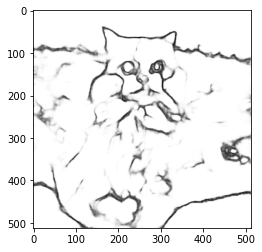

In [50]:
plt.imshow(torch.sigmoid(res[-1])[0, 0].cpu().numpy(), cmap="Greys")

7